# SMA Crossover Strategy Backtester

This notebook implements a Simple Moving Average (SMA) crossover trading strategy backtester for AMD stock data using hourly timeframes. The strategy uses two moving averages:
- Short-term SMA: 9 periods
- Long-term SMA: 20 periods

The implementation is structured in separate modules:
- `data_handler.py`: Handles data fetching and preprocessing
- `strategy.py`: Implements the SMA crossover strategy
- `backtester.py`: Executes the backtesting logic
- `performance_analyzer.py`: Analyzes and visualizes results

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import display
from datetime import datetime
from alpaca.data.timeframe import TimeFrame
import os
from dotenv import load_dotenv

# Import our custom modules
from src.data_handler import DataHandler
from src.strategy import SMAStrategy
from src.backtester import Backtester
from src.performance_analyzer import PerformanceAnalyzer

# Configure pandas display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

# Load environment variables
load_dotenv()

# Get Alpaca API credentials from environment variables
API_KEY = os.getenv('ALPACA_API_KEY')
SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')

if not API_KEY or not SECRET_KEY:
    raise ValueError("Alpaca API credentials not found in environment variables. Please check your .env file.")

In [2]:
# Configure matplotlib for notebook display
%matplotlib inline

# Set up plotting style with error handling
current_style = 'default'
try:
    # First, try the modern style
    plt.style.use('seaborn')
    current_style = 'seaborn'
except:
    try:
        # Fallback to fivethirtyeight style
        plt.style.use('fivethirtyeight')
        current_style = 'fivethirtyeight'
    except:
        # If all else fails, use the default style
        plt.style.use('default')
        current_style = 'default'

# Set figure size and DPI for better display
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Matplotlib configuration complete with style:", current_style)

Matplotlib configuration complete with style: fivethirtyeight


## 1. Load and Prepare Data

Initialize the DataHandler and load the AMD stock data. We'll add the technical indicators (SMAs) needed for our strategy.

In [4]:
# Initialize DataHandler and fetch hourly data
data_handler = DataHandler(API_KEY,SECRET_KEY)  # Removed SECRET_KEY as it's not needed
data = data_handler.fetch_data(
    symbol="AMD",
    timeframe=TimeFrame.Hour,
    start=datetime(2022, 1, 1),
    end=datetime(2025, 8, 1)
)

# Add technical indicators
data = data_handler.add_technical_indicators(sma_short=9, sma_long=20)

# Display the first few rows of data
print("Data Information:")
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print("\nFirst few rows:")
display(data.head())

Data Information:
Shape: (14188, 10)
Date range: 2022-01-03 09:00:00+00:00 to 2025-07-31 23:00:00+00:00

First few rows:


,open,high,low,close,volume,trade_count,vwap,SMA_9,SMA_20,signal
timestamp,,,,,,,,,,
2022-01-03 09:00:00+00:00,144.92,145.5500,144.50,145.05,16105.0,464.0,145.055611,NaN,NaN,0
2022-01-03 10:00:00+00:00,145.17,145.4500,145.00,145.45,11422.0,303.0,145.226117,NaN,NaN,0
2022-01-03 11:00:00+00:00,145.76,145.7900,145.50,145.62,14519.0,312.0,145.624303,NaN,NaN,0
2022-01-03 12:00:00+00:00,145.60,146.2700,145.34,145.94,109354.0,1580.0,145.638809,NaN,NaN,0
2022-01-03 13:00:00+00:00,145.40,146.1001,145.12,145.18,243594.0,3234.0,145.698598,NaN,NaN,0


## 2. Generate Trading Signals

Create an instance of our SMA strategy and generate trading signals based on the moving average crossovers.

In [5]:
# Initialize strategy
strategy = SMAStrategy(sma_short=9, sma_long=20, risk_per_trade=0.02)

# Generate signals
data = strategy.generate_signals(data)

# Display a sample of the signals
display(data[['close', 'SMA_9', 'SMA_20', 'signal', 'position']].head(10))

,close,SMA_9,SMA_20,signal,position
timestamp,,,,,
2022-01-03 09:00:00+00:00,145.0500,NaN,NaN,0,NaN
2022-01-03 10:00:00+00:00,145.4500,NaN,NaN,0,0.0
2022-01-03 11:00:00+00:00,145.6200,NaN,NaN,0,0.0
2022-01-03 12:00:00+00:00,145.9400,NaN,NaN,0,0.0
2022-01-03 13:00:00+00:00,145.1800,NaN,NaN,0,0.0
2022-01-03 14:00:00+00:00,147.9200,NaN,NaN,0,0.0
2022-01-03 15:00:00+00:00,151.1600,NaN,NaN,0,0.0
2022-01-03 16:00:00+00:00,149.7600,NaN,NaN,0,0.0
2022-01-03 17:00:00+00:00,150.0659,147.349544,NaN,0,0.0


## 3. Run Backtest

Initialize the backtester with our strategy and run it on the prepared data.

In [6]:
# Initialize and run backtester
backtester = Backtester(strategy, initial_capital=100000.0, commission=0.001)
portfolio = backtester.run(data)

# Display the first few rows of the portfolio
print("\nPortfolio Summary:")
display(portfolio.head())


Portfolio Summary:


,position_value,cash,total_value
timestamp,,,
2022-01-03 09:00:00+00:00,0.0,100000.0,100000.0
2022-01-03 10:00:00+00:00,0.0,100000.0,100000.0
2022-01-03 11:00:00+00:00,0.0,100000.0,100000.0
2022-01-03 12:00:00+00:00,0.0,100000.0,100000.0
2022-01-03 13:00:00+00:00,0.0,100000.0,100000.0


## 4. Analyze Results

Calculate performance metrics and visualize the results.

In [7]:
# Initialize analyzer
analyzer = PerformanceAnalyzer(portfolio, backtester.trades, data)

# Calculate metrics
metrics = analyzer.calculate_metrics()

# Print results
print("\nPerformance Metrics:")
print("===================")
for metric, value in metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.2%}")
    else:
        print(f"{metric}: {value}")

# Generate and display trade report
trade_report = analyzer.generate_trade_report()
print("\nTrade Statistics:")
print("================")
display(trade_report.describe())


Performance Metrics:
Total Return: -41.95%
Sharpe Ratio: -27.00%
Maximum Drawdown: -63.64%
Win Rate: 50.13%
Number of Trades: 371

Trade Statistics:


,shares,price,cost,profit,return
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,679.455526,117.026526,73.906222,34.701241,-0.080757
std,220.385240,33.030869,14.933383,2679.273231,34.546725
min,328.000000,56.594340,41.058294,-6135.862432,-79.574195
25%,500.500000,93.890610,63.584178,-1483.661732,-20.137865
50%,630.000000,111.738825,74.912738,-444.012130,-6.912772
75%,870.500000,142.515697,85.813608,793.546430,10.608508
max,1201.000000,207.169281,104.968292,12473.999095,143.423151


## 5. Visualizations

Create plots to visualize the strategy performance, including:
1. Price and SMAs
2. Portfolio Value
3. Drawdown

In [8]:
# Verify data before plotting
print("Data shape:", data.shape if 'data' in locals() else "Not available")
print("Portfolio shape:", portfolio.shape if 'portfolio' in locals() else "Not available")
print("\nAvailable columns in data:")
print(data.columns if 'data' in locals() else "Not available")

Data shape: (14188, 11)
Portfolio shape: (14188, 4)

Available columns in data:
Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'SMA_9', 'SMA_20', 'signal', 'position'], dtype='object')


/Users/yush/Documents/Career/Code/venv/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


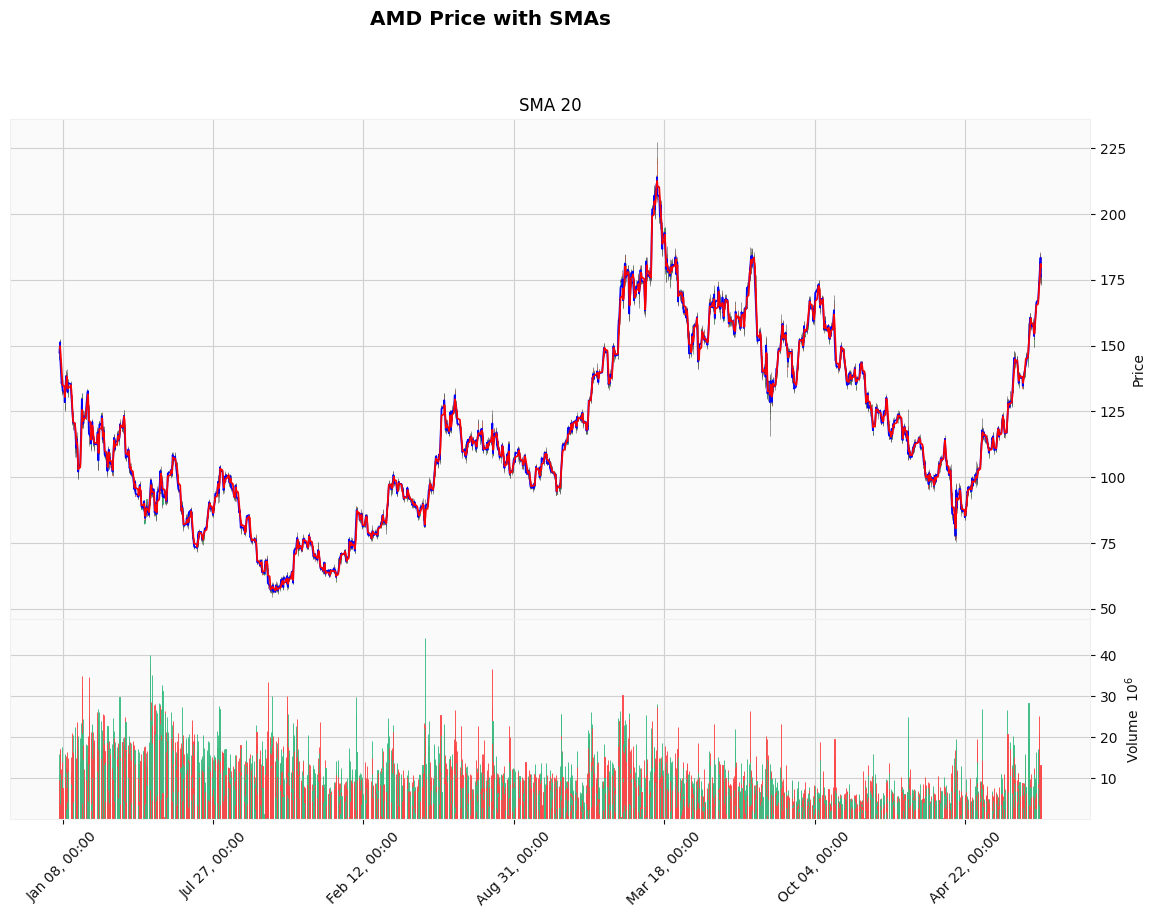

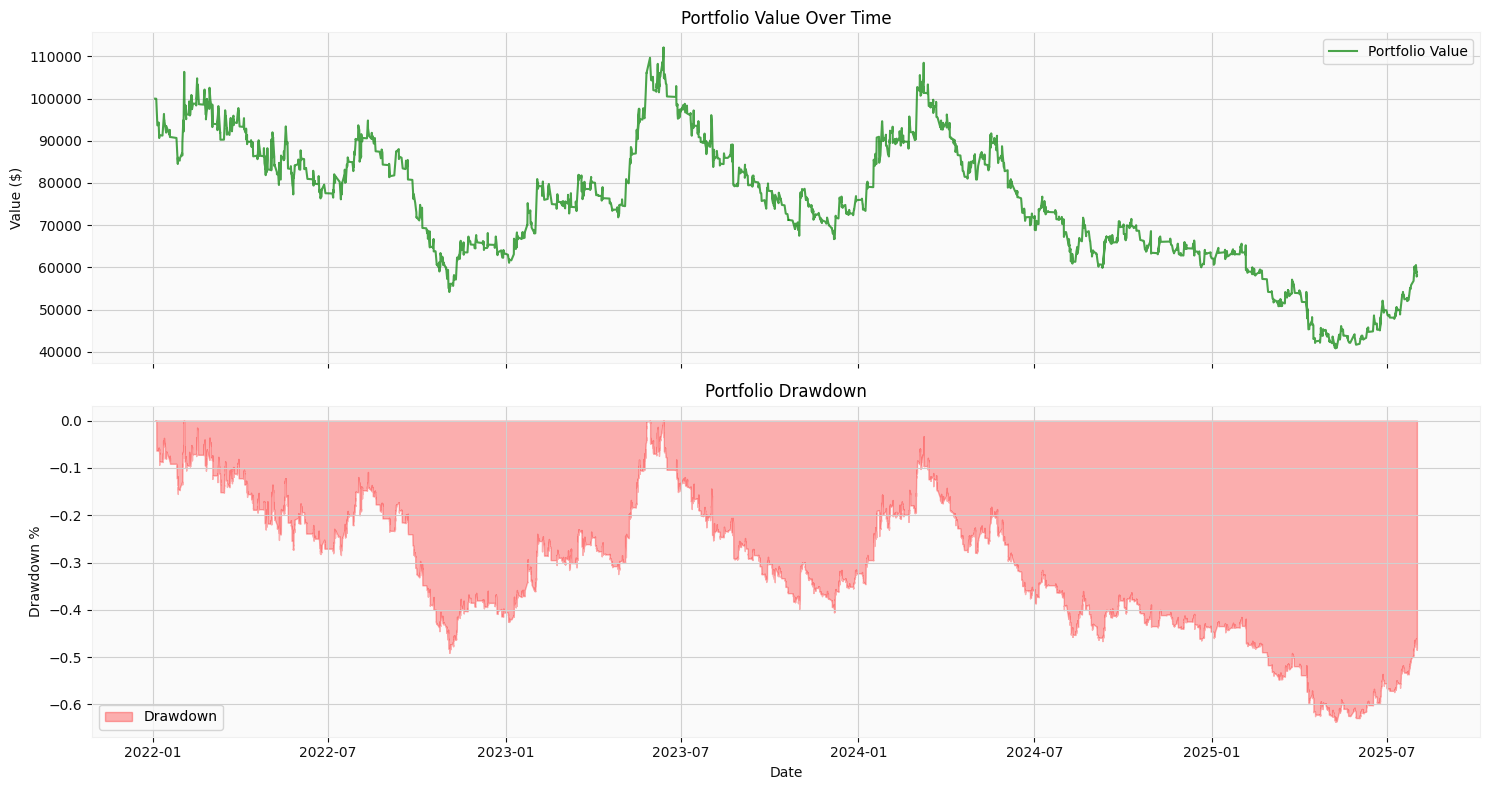

/Users/yush/Documents/Career/Code/venv/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


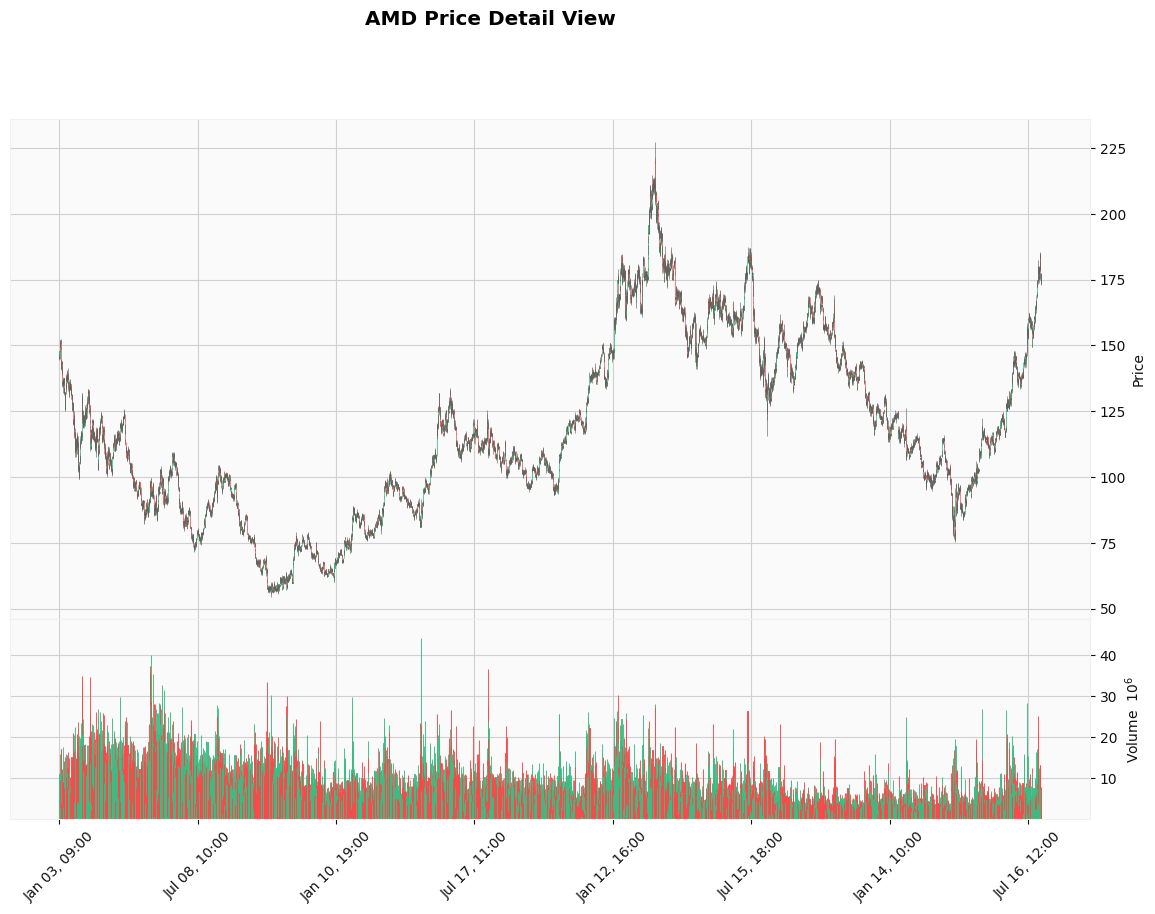

In [10]:
# Prepare the data for candlestick chart
ohlc_data = data.copy()
ohlc_data = ohlc_data.sort_index()

# Create the candlestick chart with SMAs using mplfinance (let mplfinance handle axes)
ap = [
    mpf.make_addplot(ohlc_data['SMA_9'], color='blue', title='SMA 9'),
    mpf.make_addplot(ohlc_data['SMA_20'], color='red', title='SMA 20')
]

mpf.plot(
    ohlc_data,
    type='candle',
    style='yahoo',
    title='AMD Price with SMAs',
    ylabel='Price',
    volume=True,
    addplot=ap,
    figsize=(15, 10),
    show_nontrading=True
)

# Plot Portfolio Value and Drawdown using matplotlib
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot 2: Portfolio Value
ax2.plot(portfolio.index, portfolio['total_value'], label='Portfolio Value', color='green', alpha=0.7)
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Value ($)')
ax2.legend()
ax2.grid(True)

# Plot 3: Drawdown
returns = portfolio['total_value'].pct_change()
cum_returns = (1 + returns).cumprod()
running_max = cum_returns.expanding().max()
drawdown = (cum_returns - running_max) / running_max
ax3.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
ax3.set_title('Portfolio Drawdown')
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown %')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Display additional chart with just price and volume (no overlays)
mpf.plot(
    ohlc_data,
    type='candle',
    title='AMD Price Detail View',
    ylabel='Price',
    volume=True,
    figsize=(15, 10),
    style='yahoo'
)